# Machine Learning: Training a HACTNet model

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/train_hactnet.ipynb)

In this notebook, we will train the HACTNet graph neural network (GNN) model on input cell and tissue graphs using the new `pathml.graph` API.

To run the notebook and train the model, you will have to first download the BRACS Regions of Interest (ROI) set from the [BRACS dataset](https://www.bracs.icar.cnr.it/download/). To do so, you will have to sign up and create an account. Next, you will have to construct the cell and tissue graphs using the tutorial in `examples/construct_graphs.ipynb`. Use the output directory specified there as the input to the main function in this tutorial.

NOTE: The actual HACTNet model uses HoVer-Net, an ML model, to detect cells. In `examples/construct_graphs.ipynb`, we used a manual method for simplicity. Hence the performance of the model trained in this notebook will be lesser. 

In [12]:
import os
from glob import glob
import argparse
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import h5py
import warnings
import math
from skimage.measure import regionprops, label
import networkx as nx
import traceback
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.data import Batch
from torch_geometric.data import Data
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score

from pathml.core import HESlide
from pathml.datasets import EntityDataset
from pathml.ml.utils import get_degree_histogram, get_class_weights
from pathml.ml import HACTNet

# If using GPU
device = "cuda"

# If using CPU
# device = "cpu"

## Data visualization

First, let us take a look at the inputs to our model. The dataset comrpises of approximately 3600 training ROIs, 310 validation ROIs and 560 testing ROIs. In each of these, the ROIs can belong to one out of seven possible labels, that correspond to breast cancer subtypes. Refer to Brancati et al., 2022 for more information about the dataset. Our task is to train a model that can classify the given ROI to the correct cancer subtype. 

We will now visualize one ROI from each of these seven subtypes to see the similarities and differences between them. 

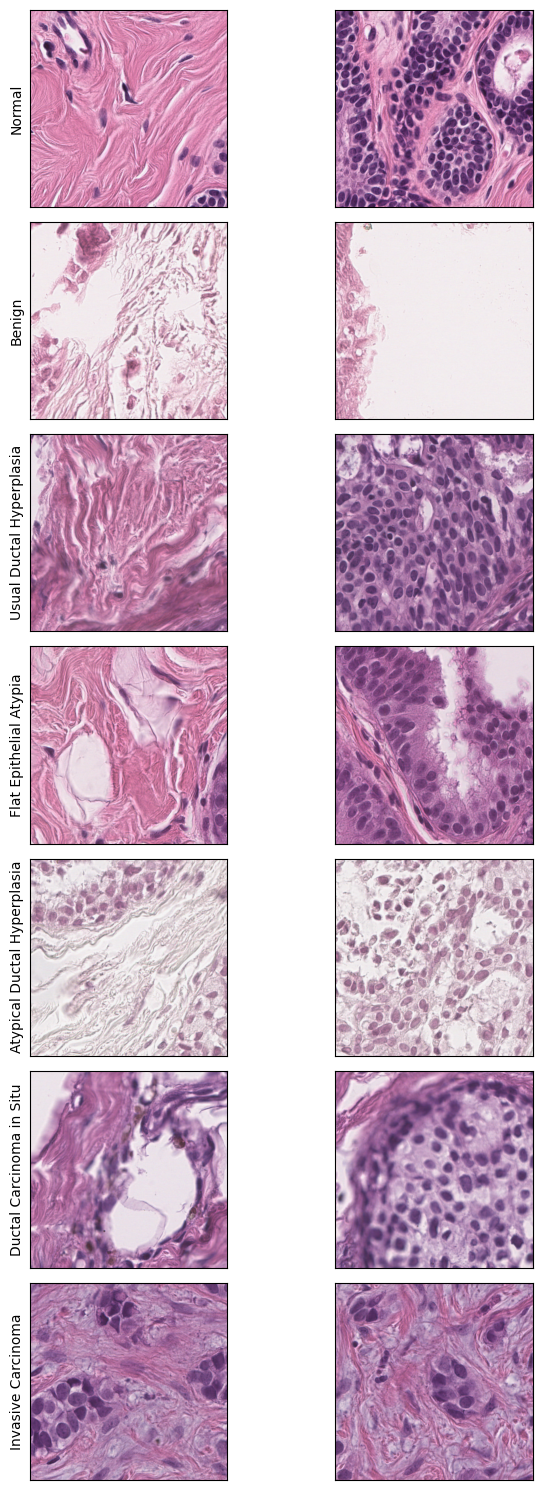

In [21]:
# PATH to the train split of the BRACS dataset 
base_path = '../../data/BRACS_RoI/latest_version/train/'

# We manually choose a random ROI to visualize along with information about its corresponding label
image_info = [('0_N/BRACS_1231_N_27.png','Normal'),
              ('1_PB/BRACS_1003671_PB_1.png', 'Benign'),
              ('2_UDH/BRACS_1003707_UDH_1.png', 'Usual Ductal Hyperplasia'),
              ('3_FEA/BRACS_1003693_FEA_1.png', 'Flat Epithelial Atypia'),
              ('4_ADH/BRACS_1003728_ADH_1.png', 'Atypical Ductal Hyperplasia'),
              ('5_DCIS/BRACS_1003697_DCIS_1.png', 'Ductal Carcinoma in Situ'),
              ('6_IC/BRACS_1003699_IC_1.png', 'Invasive Carcinoma')]

# Plot the figure
fig, axarr = plt.subplots(nrows=7, ncols=2, figsize=(7.5, 15))

for i, (image_path, label) in enumerate(image_info):
    wsi = HESlide(base_path + image_path)
    region1 = wsi.slide.extract_region(location=(0, 0), size=(500, 500))
    region2 = wsi.slide.extract_region(location=(500, 500), size=(500, 500))

    axarr[i,0].imshow(np.squeeze(region1))
    axarr[i,1].imshow(np.squeeze(region2))

    axarr[i,0].set_ylabel(label, fontsize=10)
    
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## Model Training

Now that we know the input dataset and the objective, we can proceed to training the model. The model takes constructed graphs as input, so make sure you have run `examples/construct_graphs.ipynb`. 

We can define the main training loop for loading the constructed graphs, initializing the model and training. 

In [12]:
def train_hactnet(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=4,
    load_histogram=True,
    histogram_dir=None,
    calc_class_weights=True,
):

    # Print the lengths of each dataset split
    print(f"Length of training dataset: {len(train_dataset)}")
    print(f"Length of validation dataset: {len(val_dataset)}")
    print(f"Length of test dataset: {len(test_dataset)}")

    # Define the torch_geometric.DataLoader object for each dataset split 
    train_batch = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        follow_batch=["x_cell", "x_tissue"],
        drop_last=True,
    )
    val_batch = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        follow_batch=["x_cell", "x_tissue"],
        drop_last=True,
    )
    test_batch = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        follow_batch=["x_cell", "x_tissue"],
        drop_last=True,
    )

    # The GNN layer we use in this model, PNAConv, requires the computation of a node degree histogram of the
    # train dataset. We only need to compute it once. If it is precomputed already, set the load_histogram=True.
    # Else, the degree histogram is calculated and saved.
    if load_histogram:
        histogram_dir = "./"
        cell_deg = torch.load(os.path.join(histogram_dir, "cell_degree_norm.pt"))
        tissue_deg = torch.load(os.path.join(histogram_dir, "tissue_degree_norm.pt"))
    else:
        train_batch_hist = DataLoader(
            train_dataset,
            batch_size=20,
            shuffle=True,
            follow_batch=["x_cell", "x_tissue"],
        )
        print("Calculating degree histogram for cell graph")
        cell_deg = get_degree_histogram(train_batch_hist, "edge_index_cell", "x_cell")
        print("Calculating degree histogram for tissue graph")
        tissue_deg = get_degree_histogram(
            train_batch_hist, "edge_index_tissue", "x_tissue"
        )
        torch.save(cell_deg, "cell_degree_norm.pt")
        torch.save(tissue_deg, "tissue_degree_norm.pt")

    # Since the BRACS dataset has unbalanced data, it is important to calculate the class weights in the training set
    # and provide that as an argument to our loss function.
    if calc_class_weights:
        train_w = get_class_weights(train_batch)
        torch.save(torch.tensor(train_w), "loss_weights_norm.pt")

    # Here we define the keyword arguments for the PNAConv layer in the model for both cell and tissue processing
    # layers.
    kwargs_pna_cell = {
        "aggregators": ["mean", "max", "min", "std"],
        "scalers": ["identity", "amplification", "attenuation"],
        "deg": cell_deg,
    }
    kwargs_pna_tissue = {
        "aggregators": ["mean", "max", "min", "std"],
        "scalers": ["identity", "amplification", "attenuation"],
        "deg": tissue_deg,
    }

    cell_params = {
        "layer": "PNAConv",
        "in_channels": 514,
        "hidden_channels": 64,
        "num_layers": 3,
        "out_channels": 64,
        "readout_op": "lstm",
        "readout_type": "mean",
        "kwargs": kwargs_pna_cell,
    }

    tissue_params = {
        "layer": "PNAConv",
        "in_channels": 514,
        "hidden_channels": 64,
        "num_layers": 3,
        "out_channels": 64,
        "readout_op": "lstm",
        "readout_type": "mean",
        "kwargs": kwargs_pna_tissue,
    }

    classifier_params = {
        "in_channels": 128,
        "hidden_channels": 128,
        "out_channels": 7,
        "num_layers": 2,
    }

    # Initialize the pathml.ml.HACTNet model
    model = HACTNet(cell_params, tissue_params, classifier_params)

    # Set up optimizer
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Learning rate scheduler to reduce LR by factor of 10 each 25 epochs
    scheduler = StepLR(opt, step_size=25, gamma=0.1)

    # Send the model to GPU
    model = model.to(device)

    # Define number of epochs
    n_epochs = 60

    # Keep a track of best epoch and metric for saving only the best models
    best_epoch = 0
    best_metric = 0

    # Load the computed class weights if calc_class_weights = True
    if calc_class_weights:
        loss_weights = torch.load("loss_weights.pt")

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss(
        weight=loss_weights.float().to(device) if calc_class_weights else None
    )

    # Empty list to append training losses
    train_losses = []

    # Empty list to append validation metrics (wighted F-1 score)
    train_metrics = []
    val_metrics = []
    test_metrics = []

    # Define the evaluate function to compute metrics for validation and test set to keep track of performance.
    # The metrics used are per-class and weighted F1 score.
    def evaluate(data_loader):
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data in tqdm(data_loader):
                data = data.to(device)
                outputs = model(data)
                y_true.append(
                    torch.argmax(outputs.detach().cpu().softmax(dim=1), dim=-1).numpy()
                )
                y_pred.append(data.target.cpu().numpy())
            y_true = np.array(y_true).ravel()
            y_pred = np.array(y_pred).ravel()
            per_class = f1_score(y_true, y_pred, average=None)
            weighted = f1_score(y_true, y_pred, average="weighted")
        print(f"Per class F1: {per_class}")
        print(f"Weighted F1: {weighted}")
        return np.append(per_class, weighted)

    # Start the training loop
    for i in range(n_epochs):
        print(f"\n>>>>>>>>>>>>>>>>Epoch number {i}>>>>>>>>>>>>>>>>")
        minibatch_train_losses = []

        # Put model in training mode
        model.train()

        print("Training")

        for data in tqdm(train_batch):

            # Step optimizer and scheduler
            opt.step()

            # Send the data to the GPU
            data = data.to(device)

            # Zero out gradient
            opt.zero_grad()

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = loss_fn(outputs, data.target)

            # Compute gradients
            loss.backward()

            # Track loss
            minibatch_train_losses.append(loss.detach().cpu().numpy())

        print(f"Loss: {np.array(minibatch_train_losses).ravel().mean()}")
        curr_loss = np.array(minibatch_train_losses).ravel().mean()

        # Print performance metrics on training set
        print('\nEvaluating on training')
        train_metric = evaluate(train_batch)
        
        # Print performance metrics on validation set
        print('\nEvaluating on validation')
        val_metric = evaluate(val_batch)

        # Print performance metrics on test set
        print('\nEvaluating on test')
        test_metric = evaluate(test_batch)

        # Append losses and metrics 
        train_losses.append(curr_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        test_metrics.append(test_metric)

        # Save the model only if it is better than previous checkpoint in validation metrics
        if val_metric[-1] > best_metric:
            print('Saving checkpoint')
            torch.save(model.state_dict(), "hact_net.pt")
            best_metric = val_metric[-1]
            
        # Step LR scheduler
        scheduler.step()

In [13]:
# Read the train, validation and test dataset into the pathml.datasets.EntityDataset class
root_dir = "./data/BRACS_RoI/latest_version/output/"
train_dataset = EntityDataset(
    os.path.join(root_dir, "cell_graphs/train/"),
    os.path.join(root_dir, "tissue_graphs/train/"),
    os.path.join(root_dir, "assignment_matrices/train/"),
)
val_dataset = EntityDataset(
    os.path.join(root_dir, "cell_graphs/val/"),
    os.path.join(root_dir, "tissue_graphs/val/"),
    os.path.join(root_dir, "assignment_matrices/val/"),
)
test_dataset = EntityDataset(
    os.path.join(root_dir, "cell_graphs/test/"),
    os.path.join(root_dir, "tissue_graphs/test/"),
    os.path.join(root_dir, "assignment_matrices/test/"),
)

In [14]:
# Train the model
train_hactnet(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=8,
    load_histogram=True,
    calc_class_weights=False,
)

Length of training dataset: 3627
Length of validation dataset: 311
Length of test dataset: 563

>>>>>>>>>>>>>>>>Epoch number 0>>>>>>>>>>>>>>>>
Training


100%|████████████████████████████████████████████████████████████████████████████████████| 453/453 [16:33<00:00,  2.19s/it]


Loss: 1.681248664855957

Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:19<00:00,  2.10s/it]


Per class F1: [0.14285714 0.23404255 0.         0.         0.         0.27802691
 0.71287129]
Weighted F1: 0.34292555902950034
Saving checkpoint

Evaluating on test


100%|██████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:44<00:00,  1.49s/it]

Per class F1: [0.29906542 0.34177215 0.         0.         0.         0.30291262
 0.32323232]
Weighted F1: 0.30912310035688134


## Model evaluation

Next, we will evaluate the model by looking at the training loss curves and the performance metrics at each epoch. This is useful to ensure that the model is learning effectively over time, to identify any signs of overfitting or underfitting, and to make informed decisions about early stopping, learning rate adjustments, or other hyperparameter tuning.

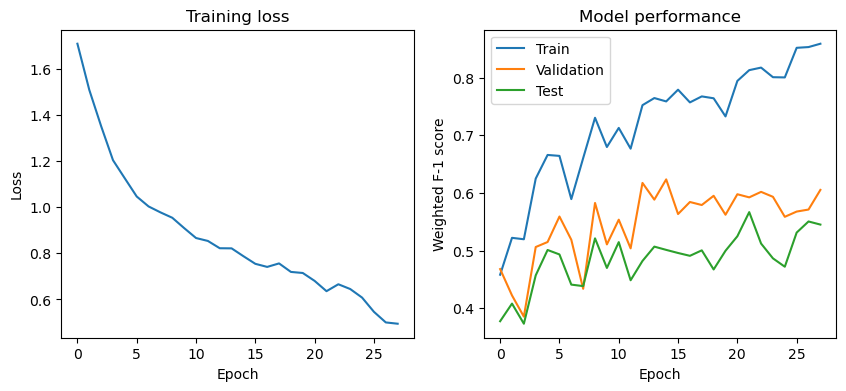

In [17]:
# Plot losses and performance metrics 
fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

epochs_range = range(0, len(train_losses))

ax[0].plot(epochs_range, train_losses, label="Train")
ax[0].set_title("Training loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs_range, train_metrics, label="Train")
ax[1].plot(epochs_range, val_metrics, label="Validation")
ax[1].plot(epochs_range, test_metrics, label="Test")

ax[1].set_title("Model performance")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Weighted F-1 score")
ax[1].legend()
plt.show()

After training the model for 20-40 epochs, you should see performance similar to the table below, depending on the dataset version you used. 


| Dataset                  | Best Weighted F-1 score |
|--------------------------|--------------------|
| BRACS (Previous version) | 60.14              |
| BRACS (Latest Version)   | 55.96              |

## References

*  Pati, Pushpak, Guillaume Jaume, Antonio Foncubierta-Rodriguez, Florinda Feroce, Anna Maria Anniciello, Giosue Scognamiglio, Nadia Brancati et al. "Hierarchical graph representations in digital pathology." Medical image analysis 75 (2022): 102264.
*  Brancati, Nadia, Anna Maria Anniciello, Pushpak Pati, Daniel Riccio, Giosuè Scognamiglio, Guillaume Jaume, Giuseppe De Pietro et al. "Bracs: A dataset for breast carcinoma subtyping in h&e histology images." Database 2022 (2022): baac093.

## Session info

In [18]:
import IPython

print(IPython.sys_info())
print(f"torch version: {torch.__version__}")

{'commit_hash': '15ea1ed5a',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/home/jupyter/miniforge3/envs/pathml_env/lib/python3.10/site-packages/IPython',
 'ipython_version': '8.10.0',
 'os_name': 'posix',
 'platform': 'Linux-4.19.0-26-cloud-amd64-x86_64-with-glibc2.28',
 'sys_executable': '/home/jupyter/miniforge3/envs/pathml_env/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.10.0 | packaged by conda-forge | (default, Nov 20 2021, '
                '02:24:10) [GCC 9.4.0]'}
torch version: 1.13.1+cu116
